In [1]:
from importlib import reload
import gnn_tracking_hpo
reload(gnn_tracking_hpo)

from gnn_tracking_hpo.util.paths import add_scripts_path

add_scripts_path()

In [2]:
from tune_fixed_ec_sectorized import load_ec, PretrainedECTrainable

In [3]:
from tune_ec_sectorized import ECTrainable
from gnn_tracking_hpo.util.paths import find_checkpoints, get_config

d = "ec-s9-pthld9"
hash = "ce8de"
checkpoint_path = find_checkpoints(d, hash)[-1]
config = get_config(d, hash)
config.update({"n_graphs_train": 1, "n_graphs_val": 100, "n_graphs_test": 1})
trainable = ECTrainable(config)
trainable.load_checkpoint(checkpoint_path, device="cpu")

DEBUG: Got config
{'batch_size': 1,
 'ec_pt_thld': 0.9,
 'focal_alpha': 0.4113666449910418,
 'focal_gamma': 1,
 'gnn_tracking_experiments_hash': 'fa26f12ec8c2ca29540c0f4ab8f4061b563eceb2',
 'gnn_tracking_hash': 'c322cac8b366756afd84432c0cd7e64ef49ff239',
 'lr': 0.0005929964890981143,
 'lw_edge': 1.0,
 'm_L_ec': 3,
 'm_alpha_ec': 0.8626651724747356,
 'm_e_dim': 4,
 'm_h_dim': 5,
 'm_hidden_dim': 208,
 'm_interaction_edge_hidden_dim': 82,
 'm_interaction_node_hidden_dim': 35,
 'n_graphs_test': 1,
 'n_graphs_train': 1,
 'n_graphs_val': 100,
 'optimizer': 'adam',
 'scheduler': None,
 'sector': 9,
 'test': False,
 'training_pt_thld': 0.0,
 'training_without_noise': False,
 'training_without_non_reconstructable': False}
INFO: Loading data to cpu memory
INFO: Loading 102 graphs (out of 371 available).
DEBUG: Parameters for data loaders: {'batch_size': 1, 'num_workers': 12}
INFO: Using device cpu


In [4]:
from gnn_tracking.training.tcn_trainer import TCNTrainer

trainer: TCNTrainer = trainable.trainer

In [110]:
import torch

trainer.model.eval()

sel = 3
with torch.no_grad():
    loader = trainer.val_loader
    for idx, data in enumerate(loader):
        if idx < sel:
            continue
        model_output = trainer.evaluate_model(data, mask_pids_reco=False)
        if idx == sel:
            break

In [111]:
import numpy as np


In [112]:
w = model_output["w"]

In [113]:
edge_index = model_output["edge_index"]

In [114]:
from gnn_tracking.metrics.losses import falsify_low_pt_edges

fixed_y = falsify_low_pt_edges(y=model_output["y"], edge_index=edge_index, pt=model_output["pt"], pt_thld=0.9)

In [115]:
thld = 0.5

In [116]:
from gnn_tracking.metrics.binary_classification import BinaryClassificationStats

In [4]:
import torch

In [31]:
def get_unconnected_node_mask(*, n_nodes, edge_index, min_connections=3):
    """Returns a mask where all nodes that do not have at least
    `min_connections edges are masked.

    Args:
        n_nodes: Total number of hits
        edge_index: Already masked
        min_connection: Minimal number of edges that a node should have

    Returns:
        Mask for hits
    """
    if min_connections <= 0:
        raise ValueError(
            "This function does not work for min_connections <= 0."
        )
    node_count_indices, node_counts = torch.unique(edge_index.flatten(), return_counts=True)
    node_mask = node_counts >= min_connections
    allowed_node_indices = node_count_indices[node_mask]
    node_indices = torch.arange(n_nodes, device=edge_index.device)
    assert len(node_indices) == n_nodes > len(node_count_indices)
    assert n_nodes > node_count_indices.max()
    return torch.isin(node_indices, allowed_node_indices)

In [32]:
assert (get_unconnected_node_mask(n_nodes=5, edge_index=torch.Tensor([
    [1, 2],
    [2, 3]
],)) == torch.Tensor([False, False, False, False, False])).all()

assert (get_unconnected_node_mask(n_nodes=5, edge_index=torch.Tensor([
    [1, 2],
    [2, 3]
]), min_connections=1) == torch.Tensor([False, True, True, True, False])).all()


In [125]:
def get_frac_removed_nodes(edge_index, w, thld):
    edge_mask = w > thld
    masked_edge_indices = edge_index[:, edge_mask]
    ei_indices, ei_counts = np.unique(masked_edge_indices.flatten(), return_counts=True)
    unique_ei_counts, ei_count_counts = np.unique(ei_counts, return_counts=True)
    assert ei_count_counts.sum() == len(ei_indices)
    return ei_count_counts[unique_ei_counts <= 2].sum() / ei_count_counts.sum()

In [126]:
thlds = np.linspace(0, 0.2, 500)
f = [get_frac_removed_nodes(edge_index, w, thld) for thld in thlds]

def getter(bcs):
    return (bcs.TP + bcs.FP)/len(bcs._y), bcs.TPR, bcs.TNR

items = np.array([getter(BinaryClassificationStats(output=w, y=fixed_y.long(), thld=thld)) for thld in thlds]).T

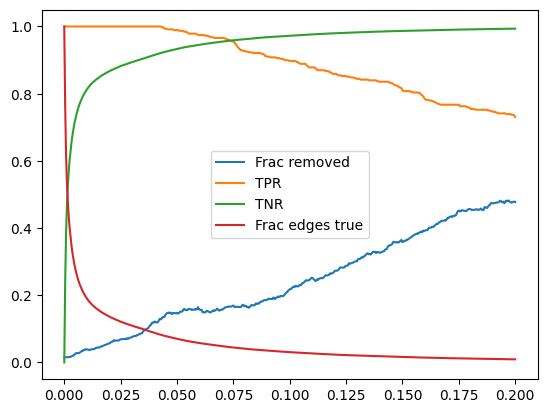

In [127]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots()
ax.plot(thlds, f, label="Frac removed")
ax.plot(thlds, items[1], label="TPR")
ax.plot(thlds, items[2], label="TNR")
ax.plot(thlds, items[0], label="Frac edges true")
ax.legend()

In [120]:
get_frac_removed_nodes(edge_index, w, 0.01)

0.04379185986604843